In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import gaussian_kde
from murre.analytics import ExponentialMovingVariance
from murre.analytics import BollingerBands
import plotly.express as px
import plotly.graph_objects as go
import math
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [282]:
data = pd.read_parquet('./murre/output/20210907_62984_trade_second_signals.parquet')
#data = pd.read_parquet('./murre/output/20210921_4627_trade_second_signals.parquet')
data['delta_vwap'] = data['vwap'].diff(periods=1)
data['volume'] = data['volume']
data['volume_given'] = data['volume_given']
data['volume_paid'] = data['volume'] - data['volume_given']
data['direct.volume'] = data['volume_paid'] - data['volume_given']
data['effective_volume'] = data['direct.volume'].abs()
data['lnQ'] = np.where(data['direct.volume'] < 0, -np.log(-data['direct.volume']), np.log(data['direct.volume']) )

/Users/rahmanw/opt/anaconda3/envs/auk/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/Users/rahmanw/opt/anaconda3/envs/auk/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



In [283]:
data

,timestamp_seconds,qty,vwap,delta_vwap_em_var,bollinger_upper,bollinger_lower,bollinger_7sma,volume,volume_given,volume_paid,delta_vwap,direct.volume,effective_volume,lnQ
0,1.630973e+18,16668.3,1.389649,NaN,NaN,NaN,1.389649,16668.3,7295.7,9372.6,NaN,2076.9,2076.9,7.638632
1,1.630973e+18,10156.0,1.389775,NaN,1.389890,1.389534,1.389712,10156.0,2581.9,7574.1,0.000126,4992.2,4992.2,8.515632
2,1.630973e+18,6499.4,1.389800,NaN,1.389903,1.389579,1.389741,6499.4,3054.3,3445.1,0.000025,390.8,390.8,5.968196
3,1.630973e+18,3284.7,1.389993,NaN,1.390089,1.389520,1.389804,3284.7,192.6,3092.1,0.000193,2899.5,2899.5,7.972294
4,1.630973e+18,3188.3,1.390079,NaN,1.390207,1.389511,1.389859,3188.3,675.0,2513.3,0.000086,1838.3,1838.3,7.516597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86690,1.631059e+18,59036.3,1.126818,0.000001,1.126166,1.121575,1.123871,59036.3,2402.1,56634.2,0.000880,54232.1,54232.1,10.901028
86691,1.631059e+18,49795.7,1.127547,0.000002,1.126886,1.121274,1.124080,49795.7,2364.9,47430.8,0.000729,45065.9,45065.9,10.715881
86692,1.631059e+18,97022.2,1.128072,0.000002,1.127616,1.121013,1.124314,97022.2,71018.9,26003.3,0.000526,-45015.6,45015.6,-10.714764
86693,1.631059e+18,79439.8,1.128917,0.000003,1.128447,1.120720,1.124583,79439.8,2531.5,76908.3,0.000844,74376.8,74376.8,11.216899


In [284]:
np.max(data['effective_volume'])

2975372.3000000003

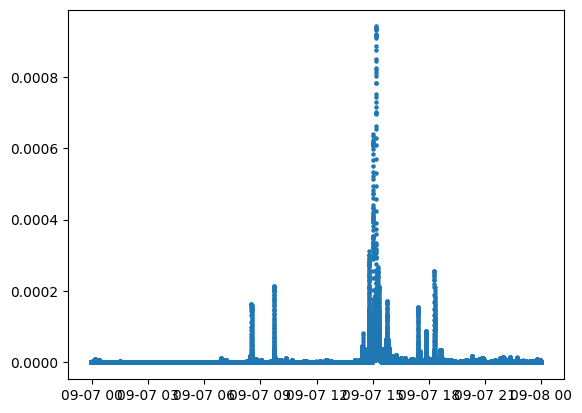

In [285]:
plt.figure()
plt.scatter(pd.to_datetime(data['timestamp_seconds']),data['delta_vwap_em_var'], s = 5)
plt.show()

In [286]:
np.mean(data['delta_vwap_em_var'])

4.373025066225806e-06

In [287]:
def fit(x, a, b):
    return a * x ** (-1 - b)

In [327]:
def fit2(x, a, b):
    return -(1+a)*x + np.log(b)

No handles with labels found to put in legend.


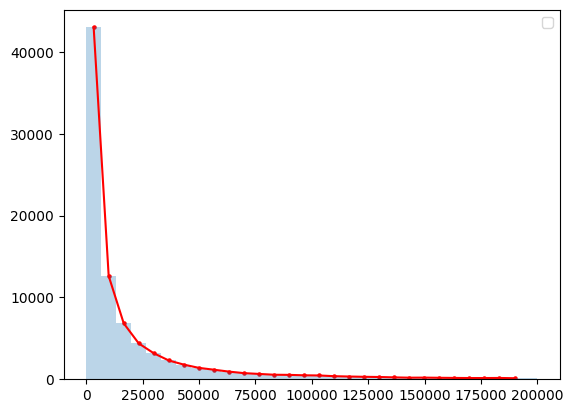

In [328]:
plt.figure()
df = data[(data['effective_volume'] > 0.1) & (data['effective_volume'] <200000)]
#df = data
n, bins, weights = plt.hist(df['effective_volume'],bins=30,alpha=0.3)

x = []
for i in range(len(bins) - 2):
    x.append((bins[i] + bins[i+1])/2)
x = np.array(x)
#plt.plot(x2,y2, color='g', label = f'{popt[0]}*x^(-1 - {popt[1]})')

plt.scatter(x,n[:-1], color='r',s=5)
plt.plot(x,n[:-1], color='r')
plt.legend()
plt.show()


In [329]:
print(n,bins)

[43026. 12625.  6840.  4382.  3181.  2296.  1792.  1395.  1169.   938.
   751.   654.   555.   538.   486.   466.   378.   336.   302.   278.
   233.   195.   203.   182.   165.   152.   151.   161.   129.   159.] [1.00000000e-01 6.66140333e+03 1.33227067e+04 1.99840100e+04
 2.66453133e+04 3.33066167e+04 3.99679200e+04 4.66292233e+04
 5.32905267e+04 5.99518300e+04 6.66131333e+04 7.32744367e+04
 7.99357400e+04 8.65970433e+04 9.32583467e+04 9.99196500e+04
 1.06580953e+05 1.13242257e+05 1.19903560e+05 1.26564863e+05
 1.33226167e+05 1.39887470e+05 1.46548773e+05 1.53210077e+05
 1.59871380e+05 1.66532683e+05 1.73193987e+05 1.79855290e+05
 1.86516593e+05 1.93177897e+05 1.99839200e+05]


In [330]:
n2 = np.log(n)
x2 = np.log(x)
#popt, pcov = curve_fit(fit, x, n[:-1], method='trf')
popt, pcov = curve_fit(fit2, x2, n2[:-1], method='trf')
print('params', popt)
x2 = np.linspace(df['effective_volume'].min(), df['effective_volume'].max(),1000)
y2 = [fit(i, popt[0], popt[1]) for i in x2]

params [5.16302477e-01 1.57879203e+10]


<ipython-input-287-d0774ff319f0>:2: RuntimeWarning:

overflow encountered in double_scalars



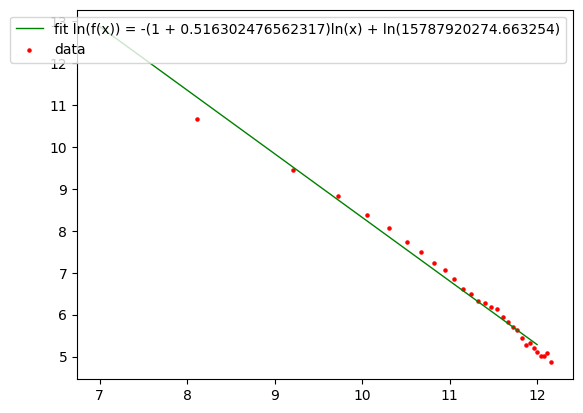

In [335]:
sim_x = np.linspace(7,12,100)
sim_y = [fit2(i,popt[0],popt[1]) for i in sim_x]

plt.figure()
plt.scatter(np.log(x), n2[:-1], label = 'data', color='r', s= 5)
plt.plot(sim_x,sim_y, label=f'fit ln(f(x)) = -(1 + {popt[0]})ln(x) + ln({popt[1]})', color='g', linewidth = 1)
plt.legend()
plt.show()

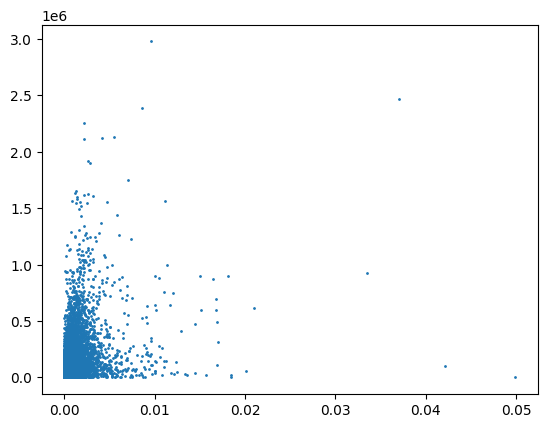

In [326]:
plt.figure()

x = abs(data['delta_vwap'])
y = data['effective_volume']#np.log(abs(data['effective_volume']))
df = pd.DataFrame({'dvwap':x,'lnQ':y})
df = df[np.isfinite(df['dvwap'])]
df = df[np.isfinite(df['lnQ'])]
plt.scatter(x,y,s=1)
#plt.xlim((0,8000))
plt.show()

In [236]:
def linfit(x,m):
    return m*x

curve_fit(linfit, df['dvwap'].values,df['lnQ'].values)[0]

array([62366357.53231835])